+ 在之前的两个示例，燃料预测和影评分类中，当训练周期到达一定次数后，模型在验证数据上的准确率达到峰值之后便开始下降。
+ 即 模型会过拟合训练数据，尽管可以在训练集上实现很高的准确率，但是泛化到测试数据上的能力却很差，而后者才是我们真正关心的
+ 与过拟合相对的是欠拟合，当测试数据仍存在上升空间时，就会发生欠拟合。
    + 出现这种情况的原因有很多，包括：
        + 模型不够强大，
        + 过于正则化
        + 没有训练足够长的时间
    + 欠拟合意味着网络未学习训练数据中的相关模式
+ 如果训练时间过长，模型将开始过拟合，无法从训练数据中学习到可以泛化到其他未见过的数据的模式。**我们需要在过拟合和欠拟合之间达到平衡，选择合适的训练周期是一个很重要的事情。**
+ 为了防止发生过拟合，最好的解决办法是使用更多的训练数据。用更多数据进行训练的模型自然能够更好的泛化
    + 就像有很多数学题，要么掌握其中的机理，要么见过更多的题型，做的时候能套模板，见过的就能做的好，没见过的就不会，说白了还是没学到精髓
+ 如果无法给与更多的训练数据，那么**次优的解决方案是使用正则化等技术，这些技术会限制模型可以存储的信息的数量和类型。如果网络只能记住少量模式，那么优化过程将迫使它专注于最突出的模型，因为这些模式更有机会更好地泛化**
+ 这个示例中，将**使用两种常见的正则化技术（权重正则化和丢弃）**，来改进IMDB影评示例

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.13.1'

## 处理数据

不会像之前的示例一样使用嵌入，而是使用独热码进行编码。（教程里翻译的是多热码，写的函数也是multi_hot_sequence 其实只是翻译问题，更大众的说法是独热码）

In [3]:
(train_data,train_labels),(test_data,test_labels)=keras.datasets.imdb.load_data(num_words=10000)

根据：

+ keras.preprocessing.text.one_hot(text, n, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ') keras文档说明可知，keras自带的文本预处理one-hot函数是处理一段文本的，而这里的trai_data是已经转为数字列表的，除非我再把它转换回单词形式，所以需要自己写一个转成one-hot的函数来处理

在网上搜索了一下，基本上独热码都是浮点数，pandas内置的独热码转换由于是默认int8类型还会导致错误，所以astype('float')没事加个浮点数确保一下

In [5]:
def one_hot_sequences(sequences,dimension):
    results=np.zeros((len(sequences),dimension))  #每个影评序列最后的向量长度就是1w。。。略长
    for i,word_indices in enumerate(sequences):
        results[i,word_indices]=1.0  #i行是第i个记录，word_indices就是这个词语对应的id 独热码，
    return results

train_data=one_hot_sequences(train_data,dimension=10000)
test_data=one_hot_sequences(test_data,dimension=10000)

由于这1w个词是根据词频排序的，所以train_data[0]这一列应该有更多的1，查看一下

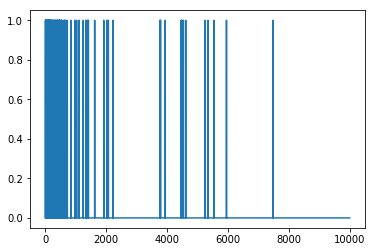

In [6]:
plt.plot(train_data[0])   #这个看起来并不是很直观吧。。。

## 演示过拟合

+ 要防止过拟合，最简单的方法就是**缩小模型，即减小模型中可学习参数的数量（由层数和每层的单元数决定）**
+ 在深度学习中，模型中可学习参数的数量通常称为模型的‘容量’。
    + 直观来说，参数越多的模型‘记忆容量’越大，因此能够轻松学习训练样本与其目标之间的字典式完美映射（这里的映射是没有任何泛化能力的映射），但是当面对之前未见过的数据时，这种映射就没用了
    + 另一方面，如果网络的记忆资源有限，便无法轻松学习映射。为了最小化损失，它必须学习具有更强预测能力的压缩表示方法。同时，如果模型太小将难以与训练数据拟合。需要在‘太多容量’和‘容量不足’之间实现平衡
+ 遗憾的是，没有什么公式可以用来确定合适的模型大小或者架构，只能自己慢慢去尝试
    + **要找到合适的模型大小，最好先使用相对较少的层和参数，然后再去增加层的大小或者新的层，直到看到返回的验证损失不断减小为止。**

### 创建基准模型

In [8]:
baseline_model=keras.Sequential([
    keras.layers.Dense(16,activation=tf.nn.relu,input_shape=(10000,)),
    keras.layers.Dense(16,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [9]:
baseline_history=baseline_model.fit(train_data,
                                   train_labels,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(test_data,test_labels),
                                   verbose=2)  #verbose只要不等于0，那就都是打印训练信息的意思

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 7s - loss: 0.5288 - acc: 0.8012 - binary_crossentropy: 0.5288 - val_loss: 0.3863 - val_acc: 0.8622 - val_binary_crossentropy: 0.3863
Epoch 2/20
 - 5s - loss: 0.2880 - acc: 0.9008 - binary_crossentropy: 0.2880 - val_loss: 0.2958 - val_acc: 0.8843 - val_binary_crossentropy: 0.2958
Epoch 3/20
 - 5s - loss: 0.2082 - acc: 0.9270 - binary_crossentropy: 0.2082 - val_loss: 0.2829 - val_acc: 0.8874 - val_binary_crossentropy: 0.2829
Epoch 4/20
 - 5s - loss: 0.1680 - acc: 0.9408 - binary_crossentropy: 0.1680 - val_loss: 0.2935 - val_acc: 0.8841 - val_binary_crossentropy: 0.2935
Epoch 5/20
 - 5s - loss: 0.1370 - acc: 0.9539 - binary_crossentropy: 0.1370 - val_loss: 0.3139 - val_acc: 0.8791 - val_binary_crossentropy: 0.3139
Epoch 6/20
 - 5s - loss: 0.1130 - acc: 0.9639 - binary_crossentropy: 0.1130 - val_loss: 0.3410 - val_acc: 0.8752 - val_binary_crossentropy: 0.3410
Epoch 7/20
 - 5s - l

### 创建一个更小的模型

创建一个隐藏单元更少的模型，与刚刚创建的基准模型进行比较

In [10]:
smaller_model=keras.Sequential([
    keras.layers.Dense(4,activation=tf.nn.relu,input_shape=(10000,)),
    keras.layers.Dense(4,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])
smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])
smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [11]:
smaller_history=smaller_model.fit(train_data,
                                   train_labels,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(test_data,test_labels),
                                   verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 5s - loss: 0.5726 - acc: 0.7558 - binary_crossentropy: 0.5726 - val_loss: 0.4904 - val_acc: 0.8135 - val_binary_crossentropy: 0.4904
Epoch 2/20
 - 4s - loss: 0.3987 - acc: 0.8864 - binary_crossentropy: 0.3987 - val_loss: 0.3742 - val_acc: 0.8766 - val_binary_crossentropy: 0.3742
Epoch 3/20
 - 5s - loss: 0.2889 - acc: 0.9190 - binary_crossentropy: 0.2889 - val_loss: 0.3180 - val_acc: 0.8838 - val_binary_crossentropy: 0.3180
Epoch 4/20
 - 5s - loss: 0.2286 - acc: 0.9323 - binary_crossentropy: 0.2286 - val_loss: 0.2958 - val_acc: 0.8865 - val_binary_crossentropy: 0.2958
Epoch 5/20
 - 5s - loss: 0.1931 - acc: 0.9408 - binary_crossentropy: 0.1931 - val_loss: 0.2921 - val_acc: 0.8842 - val_binary_crossentropy: 0.2921
Epoch 6/20
 - 5s - loss: 0.1689 - acc: 0.9479 - binary_crossentropy: 0.1689 - val_loss: 0.2917 - val_acc: 0.8843 - val_binary_crossentropy: 0.2917
Epoch 7/20
 - 5s - loss: 0.1493 - acc: 0.9553 - binary_crossentropy:

### 创建一个更大的模型

In [12]:
bigger_model=keras.Sequential([
    keras.layers.Dense(512,activation=tf.nn.relu,input_shape=(10000,)),
    keras.layers.Dense(512,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])
bigger_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])
bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [13]:
bigger_history=bigger_model.fit(train_data,
                                   train_labels,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(test_data,test_labels),
                                   verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 26s - loss: 0.3421 - acc: 0.8503 - binary_crossentropy: 0.3421 - val_loss: 0.2935 - val_acc: 0.8802 - val_binary_crossentropy: 0.2935
Epoch 2/20
 - 24s - loss: 0.1431 - acc: 0.9480 - binary_crossentropy: 0.1431 - val_loss: 0.3304 - val_acc: 0.8734 - val_binary_crossentropy: 0.3304
Epoch 3/20
 - 24s - loss: 0.0463 - acc: 0.9866 - binary_crossentropy: 0.0463 - val_loss: 0.4579 - val_acc: 0.8694 - val_binary_crossentropy: 0.4579
Epoch 4/20
 - 24s - loss: 0.0073 - acc: 0.9987 - binary_crossentropy: 0.0073 - val_loss: 0.5852 - val_acc: 0.8691 - val_binary_crossentropy: 0.5852
Epoch 5/20
 - 25s - loss: 8.6856e-04 - acc: 1.0000 - binary_crossentropy: 8.6856e-04 - val_loss: 0.6772 - val_acc: 0.8694 - val_binary_crossentropy: 0.6772
Epoch 6/20
 - 25s - loss: 2.1616e-04 - acc: 1.0000 - binary_crossentropy: 2.1616e-04 - val_loss: 0.7197 - val_acc: 0.8691 - val_binary_crossentropy: 0.7197
Epoch 7/20
 - 27s - loss: 1.3093e-04 - acc: 1.

## 绘制训练损失和验证损失图表

实线表示训练损失，虚线表示验证损失（**验证损失越低，表明模型越好**）。在这个示例中，smaller网络开始过拟合的时间比baseline模型要晚（前者在6个周期之后，后者在4个周期之后），同时过拟合开始之后，它的效果下降速度也慢得多

In [15]:
'title'.title() #title函数，不要和html里的搞混的，这个意思是返回标题化的字符串 ，也就是首字母大写其余小写的形式

'Title'

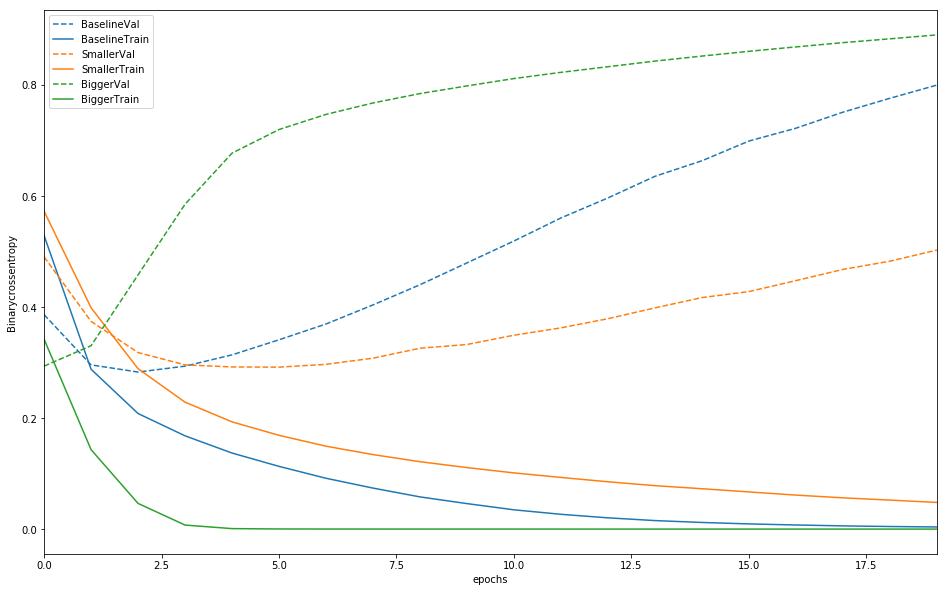

In [23]:
def plot_history(histories,key='binary_crossentropy'):
    plt.figure(figsize=(16,10))
    for name,history in histories:
        val=plt.plot(history.epoch,history.history['val_'+key],'--',label=name.title()+'Val')
        plt.plot(history.epoch,history.history[key],color=val[0].get_color(),label=name.title()+'Train')
        
    plt.xlabel('epochs')
    plt.ylabel(key.replace('_','').title())
    plt.legend()
    
    plt.xlim([0,max(history.epoch)])
    
plot_history([('baseline',baseline_history),
             ('smaller',smaller_history),
             ('bigger',bigger_history)])

可以发现，较大的网络（绿色）几乎仅仅一个周期之后便立即开始过拟合（虚线 验证损失），之后比其他两个严重的多。网络容量越大，则能够越快的对训练数据进行建模（产生较低的训练损失），但是越容易过拟合（训练损失和验证损失之间的差异很大）

## 策略（解决过拟合问题）

**添加权重正则化**

你可能听过奥卡姆剃刀定律：如果对同一种现象有两种解释，那么最简单的那个解释更可能正确，即做出最少量假设的解释，这也适用于神经网络的学习：

给定一些训练数据和一个网络架构，有多组权重值（多个模型）可以解释数据（描述数据），简单模型相对于复杂模型就不容易产生过拟合

在这种情况下，‘简单模型’是一种参数值分布的熵较低的模型（或者说所含参数比较少的模型，就像上面那个例子）。

+ 因此，要缓解过拟合，一种常见方法是限制网络的复杂性：**可以强制要求权重仅采用较小的数值，使得权重值的分布更‘规则’，这称为‘权重正则化’**，通过向网络的损失函数添加与权重较大相关的代价来实现。这个代价分为两种类型：
    + L1正则化，其中所添加的代价与权重系数的绝对值（即所谓的权重‘L1范数’）成正比
    + L2正则化，其中所添加的代价与权重系数的平方（即所谓的权重‘L2范数’）成正比。L2正则化在神经网络领域也称为权重衰减，不要因为名称不同而感到困惑，从数学角度来讲，权重衰减与L2正则化完全相同。

+ 在keras中，权重正则化的添加如下：将权重正则化实例作为关键字参数传递给层

+ 下面例子在上面的基准模型基础上添加了L2正则化

L2(0.001)表示层的权重矩阵中的每个系数都将会将0.001\*weight_coefficient_value\*\*2添加到网络的总损失中。

注意：

+ 由于这个惩罚项仅仅在训练时添加，此网络在训练时的损失要远高于测试的（看了下下面的训练，还可以，也不是高的特别离谱）

In [24]:
l2_model=keras.Sequential([
    keras.layers.Dense(16,kernel_regularizer=keras.regularizers.l2(0.001),activation=tf.nn.relu,input_shape=(10000,)),
    keras.layers.Dense(16,kernel_regularizer=keras.regularizers.l2(0.001),activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])
l2_model.summary()

l2_history=l2_model.fit(train_data,
                       train_labels,
                       epochs=20,
                       batch_size=512,
                       validation_data=(test_data,test_labels),
                       verbose=2)  #verbose只要不等于0，那就都是打印训练信息的意思

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 9s - loss: 0.5414 - acc: 0.8114 - binary_crossentropy: 0.5021 - val_loss: 0.3976 - val_acc: 0.8728 - val_binary_crossentropy: 0.3562
Epoch 2/20
 - 6s - loss: 0.3175 - acc: 0.9045 - binary_crossentropy: 0.2703 - val_loss: 0.3392 - val_acc: 0.8872 - val_binary_crossentropy: 0.2877
Epoch 3/20
 - 5s - loss: 0.2620 - acc: 0.9262 - binary_c

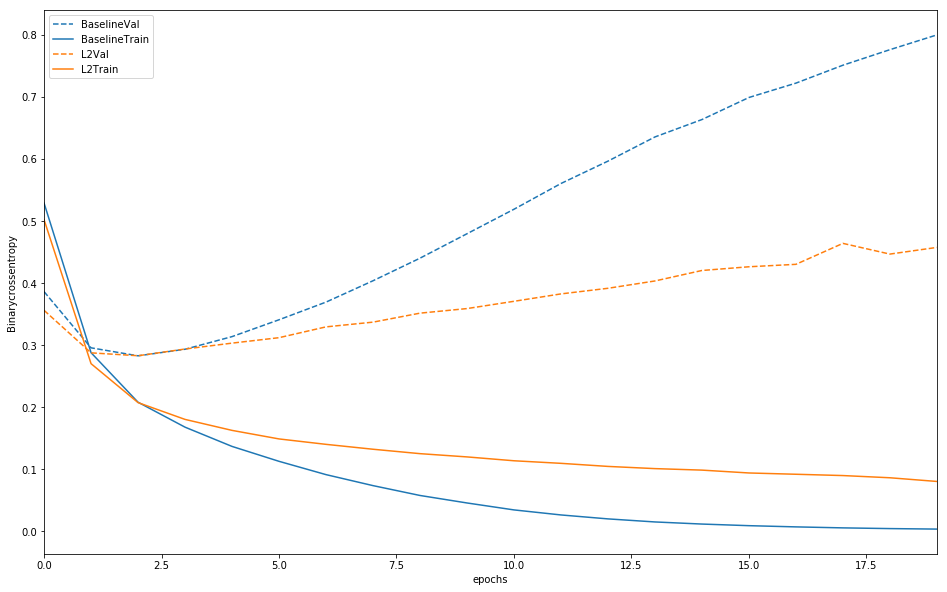

In [26]:
plot_history([('baseline',baseline_history),
             ('l2',l2_history)])

可以看到，加了L2惩罚项的模型 （橙色虚线 验证损失）的过拟合抵抗能力比基准模型强得多，在其他参数量一样的情况下。

## 添加丢弃层（dropout）

dropout是有Hinton及其在多伦多大学的学生开发的，是最有效且最常用的神经网络正则化技术之一。dropout（应用于某个层）是指在训练期间随机‘丢弃’（即设置为0）该层的多个输出特征。
+ 例如：假设某个指定的层通常会在训练期间针对给定的输入样本返回一个向量[0.2,0.5,1.3,0.8,1.1],(即某个层正常的输出给下一层的东西)，在应用dropout后，就会将这个向量中的某几个值随机置为0，例如[0,0.5,1.3,0,1.1]。dropout ratio指变为0的特征所占的比例，通常设置在0.2到0.5之间，**而在测试时，网络不会丢弃任何单元，而是将层的输出值按等同于dropout的比例进行缩减**，以平衡测试阶段比训练阶段有更多activate units的这个问题
+ 在keras中，可以通过使用Dropout层来向网络加入dropout,会对dropout之前的一个层发挥作用

+ https://www.jianshu.com/p/32c3a1ab0f9d 这个文章貌似讲的不错，但是我没看的很懂

In [28]:
dpt_model=keras.models.Sequential([
    keras.layers.Dense(16,activation=tf.nn.relu,input_shape=(10000,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16,activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])
dpt_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy','binary_crossentropy'])
dpt_model_history=dpt_model.fit(train_data,train_labels,epochs=20,batch_size=512,validation_data=(test_data,test_labels),verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 9s - loss: 0.6453 - acc: 0.6101 - binary_crossentropy: 0.6453 - val_loss: 0.5411 - val_acc: 0.8263 - val_binary_crossentropy: 0.5411
Epoch 2/20
 - 5s - loss: 0.5050 - acc: 0.7831 - binary_crossentropy: 0.5050 - val_loss: 0.4018 - val_acc: 0.8750 - val_binary_crossentropy: 0.4018
Epoch 3/20
 - 5s - loss: 0.3973 - acc: 0.8478 - binary_crossentropy: 0.3973 - val_loss: 0.3232 - val_acc: 0.8845 - val_binary_crossentropy: 0.3232
Epoch 4/20
 - 5s - loss: 0.3269 - acc: 0.8830 - binary_crossentropy: 0.3269 - val_loss: 0.2860 - val_acc: 0.8885 - val_binary_crossentropy: 0.2860
Epoch 5/20
 - 5s - loss: 0.2780 - acc: 0.9046 - binary_crossentropy: 0.2780 - val_loss: 0.2790 - val_acc: 0.8901 - val_binary_crossentropy: 0.2790
Epoch 6/20
 - 5s - loss: 0.2416 - acc: 0.9194 - binary_crossentropy: 0.2416 - val_loss: 0.2874 - val_acc: 0.8844 - val_binary_crossentropy: 0.2874
Epoch 7/20
 - 6s - loss: 0.2096 - acc: 0.9294 - binary_crossentropy:

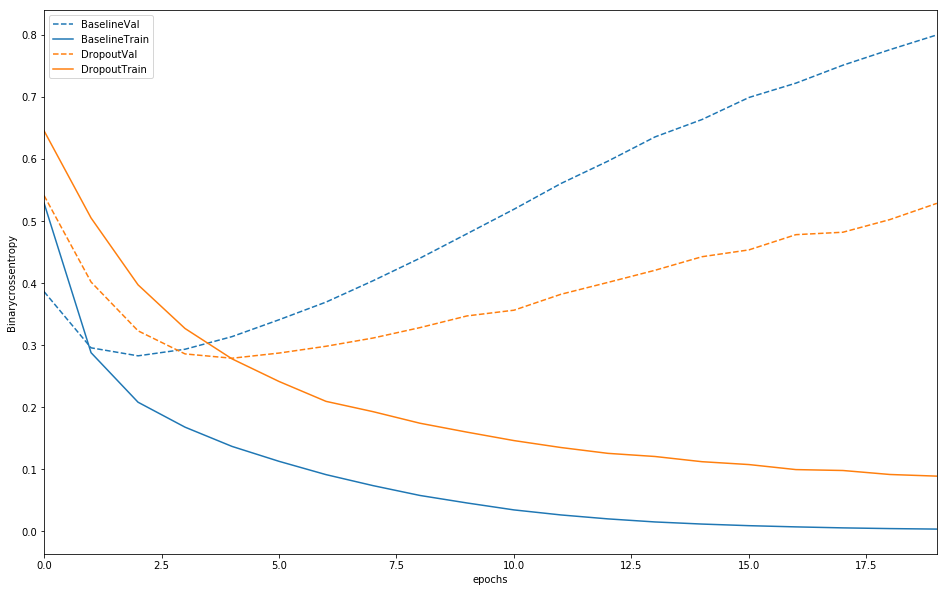

In [29]:
plot_history([('baseline',baseline_history),
             ('dropout',dpt_model_history)])

可以看到，加了dropout之后的橙色虚线，明显有了很大的提高，不仅出现过拟合的时间慢了，而且程度也小了

## 总结

防止神经网络过拟合的最常见方法：

+ 获取更多训练数据
+ 降低网络容量
+ 添加权重正则化，L1和L2正则
+ 使用dropout层